In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.stats import wasserstein_distance
from sklearn.preprocessing import QuantileTransformer
import re
from tqdm.auto import tqdm
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score


print("pytorch version:", torch.__version__)
print("GPU", "available" if torch.cuda.is_available() else "not available")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pytorch version: 1.11.0
GPU available


In [9]:
def visual_frame ( sample, N=15, M=5):

    fig, axes = plt.subplots(1,3,  figsize=(N, M))
    x = 1  
    for i in range(3):
            ax = axes[i]
            ax.imshow(sample[i], cmap='hot', interpolation='nearest')
            ax.axis('off')
            mask = (sample[i] == x)
                # Get the indices where the mask is True
            indices = torch.nonzero(mask)


    plt.tight_layout()
    plt.show()
    

# Build Custom Dataset

In [10]:
shiftTypes = { 
            'NoShift': 0,
            'moveLeftRight': 1,
            'moveUpDown': 2,
        }

shiftTypesNumber_to_word = {v: k for k, v in shiftTypes.items()}


In [11]:


class CustomDataset(Dataset):
    def __init__(self,
                 num_samples = 1000,
                 numberOfSubDetectors = 3,
                 subDetector_width = 64,
                 subDetector_height = 64,
                 numberOfTracksRange=(10,15),
                 numberOfNoiseRange=(5,10),
                 noisy=True,
                 random_seed=42,
                 shift_type= None,
                 shift_LeftRightRange=(-5,+5),
                 shift_UpDownRange=(-5,+5),
                 sh_id = None,
                 shift_value = None,
                 mykeys = None
                ):
        
        if random_seed is not None:
            np.random.seed(random_seed)
            torch.manual_seed(random_seed)

        self.num_samples = num_samples
        self.numberOfSubDetectors = numberOfSubDetectors
        self.subDetector_width= subDetector_width
        self.subDetector_height = subDetector_height
        self.numberOfTracksRange = numberOfTracksRange
        self.numberOfNoiseRange = numberOfNoiseRange
        self.noisy= noisy
        self.shift_LeftRightRange= shift_LeftRightRange
        self.shift_UpDownRange=shift_UpDownRange
        self.SubDetectorWithShift=0
        self.shift_type=shift_type
        self.shift_value= shift_value
        self.sh_id = sh_id
        self.mykeys = mykeys
            
    def __len__(self):
        return self.num_samples
    
    def shift_tensor(self, tensor, axis, n):
        shifted_tensor = tensor.clone()
        if axis == 0:
            if n>0:
                shifted_tensor = torch.cat([tensor[n:,:], torch.zeros_like(tensor[:n,:])], dim=0)
            elif n<0:
                shifted_tensor = torch.cat([torch.zeros_like(tensor[:-n,:]),tensor[:n,:]], dim=0)
            else:
                raise ValueError("shifting value should be integer not 0.")

        elif axis == 1:
            if n>0:
                shifted_tensor = torch.cat([torch.zeros_like(tensor[:,:n]),tensor[:,:-n]], dim=1)

            elif n<0:
                shifted_tensor = torch.cat([tensor[:,-n:], torch.zeros_like(tensor[:,:-n])], dim=1)

            else:
                raise ValueError("shifting value should be integer not 0.")
        else:
            raise ValueError("Axis must be 0 (up down) or 1 (left right).")
        return shifted_tensor
    
    def shift(self, tensor, shift_type, sh_id):
         # 0:noShift, 1:shift along subDetector_width, 2:shift along subDetector_height
        axis=None
        shift_value=None
        shifted_tensor = tensor.clone()
        if shift_type == shiftTypes['moveLeftRight']:
            axis=1
            if self.shift_value is not None:
                shift_value = self.shift_value
            else:
                shift_value = 0
                while shift_value == 0:
                    shift_value=np.random.randint(self.shift_LeftRightRange[0], self.shift_LeftRightRange[1]+1)
            
        elif shift_type == shiftTypes['moveUpDown']:
            axis=0
            if self.shift_value is not None:
                shift_value = self.shift_value
            else:
                shift_value = 0
                while shift_value == 0:
                    shift_value=np.random.randint(self.shift_UpDownRange[0], self.shift_UpDownRange[1]+1)
        
        self.SubDetectorWithShift=sh_id
        shifted_matrix = self.shift_tensor(shifted_tensor[sh_id], axis, shift_value)
        shifted_tensor[sh_id] = shifted_matrix

        return shifted_tensor

    
    def __len__(self):
        return self.num_samples
    

    def __getitem__(self, idx):
        
        tensor = torch.zeros(self.numberOfSubDetectors, self.subDetector_width, self.subDetector_height,
                             dtype=torch.float32)
        
        # Randomly choose the number of cells for each subdetector
        num_of_tracks = np.random.randint(low= self.numberOfTracksRange[0],high=self.numberOfTracksRange[1])
        
        # Randomly choose num_cells[i] indices to set to 1
        indices = np.random.choice(self.subDetector_width * self.subDetector_height, num_of_tracks, replace=False)
        row_indices = indices // self.subDetector_height
        col_indices = indices % self.subDetector_height
            
        for i in range(self.numberOfSubDetectors):
            tensor[i, row_indices, col_indices] = 1.0
        
        if self.shift_type is None:
            # shift_type = np.random.choice([shiftTypes['NoShift'], shiftTypes['moveLeftRight'], shiftTypes['moveUpDown']])
            shift_type = np.random.choice([shiftTypes[x] for x in self.mykeys])
        else:
            shift_type=self.shift_type
        
        shiftedTensor=tensor.clone()
        shift_values_all_misalignment = torch.zeros(6)
        # print('----')
        # print(np.where(shiftedTensor.cpu().detach().numpy()[self.sh_id]==1.0))

        if shift_type==shiftTypes['NoShift']:
            self.SubDetectorWithShift= 0
            shift_value = 0
        else:
            # sh_id=np.random.choice([0,1,2])
            if self.sh_id is not None:
                sh_id = self.sh_id
            shiftedTensor=self.shift(tensor, shift_type, sh_id) 
            
        # print(np.where(shiftedTensor.cpu().detach().numpy()[self.sh_id]==1.0))
        if self.noisy==True:
            
            for subDect_id in range(self.numberOfSubDetectors):
                
                num_of_noisy_cells= np.random.randint(low= self.numberOfNoiseRange[0],high=self.numberOfNoiseRange[1])   
                indices_of_noisy_cells= np.random.choice(self.subDetector_width * self.subDetector_height,
                                                         num_of_noisy_cells, replace=False)
            
                row_indices = indices_of_noisy_cells // self.subDetector_height
                col_indices = indices_of_noisy_cells % self.subDetector_height
                
                for  itr_row, itr_col in zip(row_indices, col_indices):
                    ns= torch.rand(1)
                    if tensor[subDect_id, itr_row, itr_col] != 1.:
                        tensor[subDect_id, itr_row, itr_col] = ns
                    if shiftedTensor[subDect_id, itr_row, itr_col] != 1.:
                        shiftedTensor[subDect_id, itr_row, itr_col] = ns
        
        # print(np.where(shiftedTensor.cpu().detach().numpy()[self.sh_id]==1.0))
        return {'subDetectors_frames': tensor,
                'shiftedSubDetectors_frames':shiftedTensor,
                'number_of_tracks': len(indices),
                'num_of_tracks':num_of_tracks,
                'shift_type': shift_type,
                'shift_value' : self.shift_value,
                'SubDetectorWithShift':self.SubDetectorWithShift,
                # 'shift_values_all_misalignment' :shift_values_all_misalignment
               }

In [12]:
shiftTypes

{'NoShift': 0, 'moveLeftRight': 1, 'moveUpDown': 2}

In [13]:

def correct_tensor_global(tensor, axis, n, sh_id):
        shifted_tensor = tensor[sh_id].clone()
         # Select the channel to use for filling the gaps
        channel_cor_from = 0 # let it now be 0 , because we know we only moved channel 1
        fill_tensor = tensor[channel_cor_from].clone()
        
        if axis == 0:
            if n>0:
                shifted_tensor = torch.cat([tensor[sh_id][n:,:], fill_tensor[:n,:]], dim=0)
            elif n<0:
                shifted_tensor = torch.cat([fill_tensor[:-n,:],tensor[sh_id][:n,:]], dim=0)
            else:
                pass
                # raise ValueError("shifting value should be integer not 0.")

        elif axis == 1:
            if n>0:
                shifted_tensor = torch.cat([fill_tensor[:,:n],tensor[sh_id][:,:-n]], dim=1)

            elif n<0:
                shifted_tensor = torch.cat([tensor[sh_id][:,-n:], fill_tensor[:,:-n]], dim=1)

            else:
                pass
                # raise ValueError("shifting value should be integer not 0.")
        else:
            raise ValueError("Axis must be 0 (up down) or 1 (left right).")
            
        tensor[sh_id]= shifted_tensor 
        return tensor


### Gan model

In [14]:
import torch.nn.init as init
from torch import nn
import torch.nn.functional as F

def weight_init(m):
    '''
    Usage:
        model = Model()
        model.apply(weight_init)
    '''
    if isinstance(m, nn.Conv1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.BatchNorm1d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm3d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight.data)
        init.normal_(m.bias.data)
    elif isinstance(m, nn.LSTM):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.LSTMCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.GRU):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.GRUCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)



class Generator(nn.Module):
    def __init__(self, numChannels):
        super().__init__()
        self.mean_shift_value = None
        self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=16,
                               kernel_size=(3, 3), padding=1)
        self.batch_norm1 = nn.BatchNorm2d(16)
        self.relu1 = nn.LeakyReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32,
#        self.conv2 = nn.Conv2d(in_channels=16, out_channels=64,

                               kernel_size=(3, 3))
#        self.batch_norm2 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.relu2 = nn.LeakyReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        ##
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64,
                               kernel_size=(3, 3))
        self.batch_norm3 = nn.BatchNorm2d(64)
        self.relu3 = nn.LeakyReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        ##
        ##
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128,
                               kernel_size=(2, 2))
        self.batch_norm4 = nn.BatchNorm2d(128)
        self.relu4 = nn.LeakyReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
       
        # the next lines commented beacuse the size is smaller 24*24, instead of 3200 to 576
        # self.fc1_1 = nn.Linear(in_features=3200, out_features=256)
        self.fc1_1 = nn.Linear(in_features=576, out_features=256)
        
        self.relu1_1 = nn.LeakyReLU()
        self.fc1_2 = nn.Linear(in_features=256, out_features=1)

        
#         self.fc_classif_1 = nn.Linear(in_features=3200, out_features=256)
#         self.relu_classif_1 = nn.LeakyReLU()

#         self.fc_classif_2 = nn.Linear(in_features=256, out_features=2)

        for tensor in [self.conv1, self.conv2, self.conv3, self.conv4, self.fc1_1,
                       self.fc1_2]:
            torch.nn.init.kaiming_uniform_(tensor.weight)

    def forward(self, x):
        corrected_tensor = x.clone()
        
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.batch_norm1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.batch_norm2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.batch_norm3(x)
        # the next lines commented beacuse the size is smaller 24*24
#         x = self.maxpool3(x)

#         x = self.conv4(x)
#         x = self.relu4(x)
#         x = self.batch_norm4(x)
        #not this one
        # x = nn.AvgPool2d(kernel_size=3, stride=2)(x)
        x = torch.flatten(x, 1)
        
        output1_1 = self.fc1_1(x)
        output1_1 = self.relu1_1(output1_1)
        output1_2 = self.fc1_2(output1_1)
        
        
#         output_classif_1 = self.fc_classif_1(x)
#         output_classif_1 = self.relu_classif_1(output_classif_1)
#         output_classif_2 = self.fc_classif_2(output_classif_1)
#         return  output_classif_2

        # Convert the output to an integer shift value
        # print(output1_2.shape)
    
        # Apply the shift for a specific channel (e.g., channel 0)
        sh_id = 1  # Index of the channel to shift / now we know it's the 1 
        shift_type = shiftTypes['moveUpDown']  # now we know it's moveUpDown 
        self.mean_shift_value = round(output1_2.mean().item()) #let's take the mean now

        # print('shift_value',self.mean_shift_value)
        
        # Apply shift to each sample in the batch
        for i in range(corrected_tensor.size(0)):
            # shift_value = output1_2[i].item()
            # print('shift_value', shift_value)
            shifted_matrix = correct_tensor_global(corrected_tensor[i], axis=0, n=-self.mean_shift_value,sh_id=sh_id) #-sign beacuse the correction in the oppisite way 
            corrected_tensor[i] = shifted_matrix

        # return  output1_2
        # print(corrected_tensor.shape)
        
        
        # Return the final corrected tensor
        return corrected_tensor
    

       
        


    
class Discriminator(nn.Module):
    def __init__(self, in_dim=40, dim=64):
        super().__init__()

        def conv_ln_lrelu(in_dim, out_dim, kernel_size=3, padding=1, stride=1):
            return nn.Sequential(
                nn.Conv2d(in_dim, out_dim, kernel_size, padding=padding, stride=stride),
                nn.InstanceNorm2d(out_dim, affine=True),
                nn.LeakyReLU(0.2))

        self.ls = nn.Sequential(
            nn.Conv2d(in_dim, dim, kernel_size=3, padding=1), nn.LeakyReLU(0.2),
            conv_ln_lrelu(dim, dim*2, kernel_size=3, padding=1),
            conv_ln_lrelu(dim*2, dim * 2),
            conv_ln_lrelu(dim * 2, dim),
            nn.Conv2d(dim, 1, 4), # [B,1,21,21]
            nn.MaxPool2d(21)) # [B,1,1,1]

        self.apply(weight_init)
        # init weights
        # torch.nn.init.kaiming_uniform_()

    def forward(self, x):
        y = self.ls(x)
        y = y.view(-1)
        return y



g = Generator(3).to(device)
d = Discriminator(in_dim=3, dim=64).to(device)

In [15]:
from torchsummary import summary

summary(g,(3,24,24))
summary(d,(3,24,24))
print(f"Mean shift value: {g.mean_shift_value}")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 24, 24]             448
         LeakyReLU-2           [-1, 16, 24, 24]               0
       BatchNorm2d-3           [-1, 16, 24, 24]              32
         MaxPool2d-4           [-1, 16, 12, 12]               0
            Conv2d-5           [-1, 32, 10, 10]           4,640
         LeakyReLU-6           [-1, 32, 10, 10]               0
       BatchNorm2d-7           [-1, 32, 10, 10]              64
         MaxPool2d-8             [-1, 32, 5, 5]               0
            Conv2d-9             [-1, 64, 3, 3]          18,496
        LeakyReLU-10             [-1, 64, 3, 3]               0
      BatchNorm2d-11             [-1, 64, 3, 3]             128
           Linear-12                  [-1, 256]         147,712
        LeakyReLU-13                  [-1, 256]               0
           Linear-14                   

NameError: name 'batch' is not defined

shift_type tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
SubDetectorWithShift tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
shift_value tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])


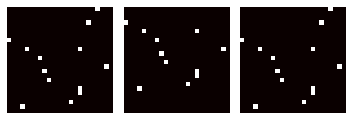

test visual with correction


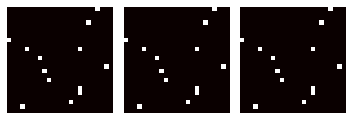

The actual without shift


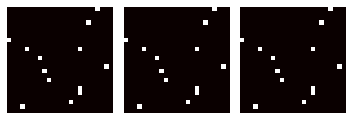

shift_type tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
SubDetectorWithShift tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
shift_value tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])


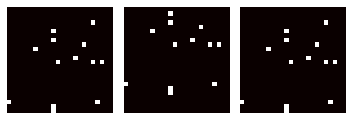

test visual with correction


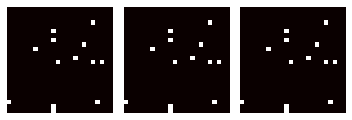

The actual without shift


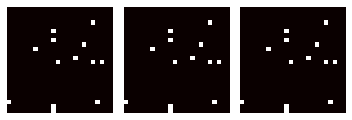

In [19]:
num_samples = 10000
numberOfSubDetectors = 3
subDetector_width = 24
subDetector_height = 24

shift_type=shiftTypes['moveUpDown']

shift_value=real_shift_value=4
# shifting subdetector 
sh_id = 1

dataset = CustomDataset(num_samples, numberOfSubDetectors, subDetector_width, subDetector_height,
                        shift_value=shift_value,
                        sh_id = sh_id,
                        shift_type=shift_type,
                        noisy=False
                       )

batch_size= 64

train_loader = DataLoader(dataset, batch_size=batch_size)

for batch in [next(iter(train_loader)), next(iter(train_loader))]: 
    print('shift_type', batch['shift_type'])
    print('SubDetectorWithShift', batch['SubDetectorWithShift'])
    print('shift_value', batch['shift_value']) 
    visual_frame(batch['shiftedSubDetectors_frames'][2], 5,2.5)
    print( 'test visual with correction')
    visual_frame(correct_tensor_global(batch['shiftedSubDetectors_frames'][2], 0, -shift_value,sh_id), 5,2.5)
    
    print( 'The actual without shift')
    
    visual_frame(batch['subDetectors_frames'][2], 5,2.5)
    

### Training loop

In [22]:
from comet_ml import Experiment
from comet_ml.integration.pytorch import log_model
log= False
if log: 
    
    experiment = Experiment(
      api_key="U4nXlyunaf2RKAIp1UtGkzlSL",
      project_name="tracks-detectors-wgan",
      workspace="saraaali"
    )

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

g = Generator(3).to(device)
d = Discriminator(in_dim=3, dim=64).to(device)

# d_optimizer = torch.optim.Adam(d.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(d.parameters(), lr=0.01, betas=(0.5, 0.999))
# g_optimizer = torch.optim.Adam(g.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(g.parameters(), lr=0.01, betas=(0.5, 0.999))

# Create a directory to save models
os.makedirs('saved_models', exist_ok=True)

def save_checkpoint(epoch,step_cnt, g, d, g_optimizer, d_optimizer, checkpoint_dir='saved_models'):
    torch.save({
        'epoch': epoch,
        'step_cnt': step_cnt,
        'generator_state_dict': g.state_dict(),
        'discriminator_state_dict': d.state_dict(),
        'g_optimizer_state_dict': g_optimizer.state_dict(),
        'd_optimizer_state_dict': d_optimizer.state_dict()
    }, os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}.pth'))

def load_checkpoint(g, d, g_optimizer, d_optimizer, checkpoint_path):
    if os.path.isfile(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        g.load_state_dict(checkpoint['generator_state_dict'])
        d.load_state_dict(checkpoint['discriminator_state_dict'])
        g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
        d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
        epoch= checkpoint['epoch']
        step_cnt= checkpoint.get('step_cnt',0)
        return epoch,step_cnt
    else:
        return 0,0

def extract_epoch_number(checkpoint_filename):
    match = re.search(r'checkpoint_epoch_(\d+)\.pth', checkpoint_filename)
    if match:
        return int(match.group(1))
    return -1

# Load checkpoint if it exists
checkpoint_dir = 'saved_models'
checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.startswith('checkpoint_epoch_')]

# Sort checkpoint files by epoch number
checkpoint_files.sort(key=extract_epoch_number)

latest_checkpoint = checkpoint_files[-1] if checkpoint_files else None

start_epoch , step_cnt=0, 0
if latest_checkpoint:
    checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)
    start_epoch,step_cnt = load_checkpoint(g, d, g_optimizer, d_optimizer, checkpoint_path)

print(f"Resuming from epoch {start_epoch}, step {step_cnt}")



d.train()
g.train()
n_epochs = 5000

len_iteration = len(train_loader)  

save_interval = 5

with tqdm(total=n_epochs*len_iteration, desc=f"[D loss: ?] [G loss: ?]") as pbar:
    for epoch in range(start_epoch, n_epochs):

        
        for tracks in train_loader:
            
            
            detector_original = tracks['subDetectors_frames'].to(device) 
            detector_damaged = tracks['shiftedSubDetectors_frames'].to(device) 

        
            d_optimizer.zero_grad()
            
            detector_original_fake = g(detector_damaged)
            d_fake = d(detector_original_fake)
            d_real = d(detector_original)
            
            d_loss = -torch.mean(d_real)+torch.mean(d_fake)
            d_loss.backward()
            d_optimizer.step()
            
            
            g_optimizer.zero_grad()
            detector_original_fake = g(detector_damaged)
            d_fake = d(detector_original_fake)
            d_real = d(detector_original)
            
            g_loss = -torch.mean(d_fake)
            g_loss.backward()
            g_optimizer.step()
            

            if log==True:
                experiment.log_metric('Disc loss', d_loss.item(), epoch=epoch, step = step_cnt)
                experiment.log_metric('Gen loss', g_loss.item(), epoch=epoch, step = step_cnt)

            step_cnt += 1
    
    
            
            pbar.set_description(f"[D loss: {d_loss.item():.2f}] [G loss: {g_loss.item():.2f}]")
            pbar.update(1)
            
            if (step_cnt%20):
                predicted_shift_value=  g.mean_shift_value 
        
                diff = abs(real_shift_value - predicted_shift_value )
                # print('diff',diff)

                if log==True:
                    experiment.log_metric('absolut_error',diff, epoch=epoch,step = step_cnt)


                    # #  R^2 score
                    # r2 = r2_score(real_shift_value, predicted_shift_value)
                    # experiment.log_metric('R^2', r2, epoch=epoch, step=step_cnt)
    

                
                
         # Check if it's time to save the model
        # save_checkpoint(epoch, step_cnt, g, d, g_optimizer, d_optimizer)
        print('diff',diff, ', predicted_value=',g.mean_shift_value )
                

            
    
        
        

if log==True:
    experiment.end()

Resuming from epoch 0, step 0


[D loss: ?] [G loss: ?]:   0%|          | 0/785000 [00:00<?, ?it/s]

KeyboardInterrupt: 